## packages

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import tensorflow as tf
from tensorflow import keras


## data pre-processing

### learn the data

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
# train.shape = (42000,785), 42000 records, each record size is 1+28*28 
# test.shape = (28000,784), no label column, each record size is 28*28
train.shape,test.shape

((42000, 785), (28000, 784))

In [3]:
# extract ytrain
ytrain = train['label']
xtrain = train.drop('label',axis=1)
ntrain = xtrain.shape[0]
# dimension
dim = np.sqrt(xtrain.shape[1]).astype(np.int64)

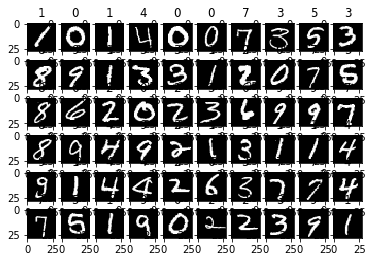

In [4]:
xtrain_vis = xtrain.values.reshape(ntrain,dim,dim)
for i in range(0,60):
    plt.subplot(6,10,1+i)
    plt.imshow(xtrain_vis[i],cmap=plt.get_cmap('gray'))
    plt.title(ytrain[i])

### pre-processing

In [5]:
# normalization
xtrain = xtrain / 255.0
test = test / 255.0

In [6]:
# reshape image
def df_reshape(df):
    df = df.values.reshape(-1,dim,dim,1)
    print("after reshape, pixels are 28*28*1 3D matrix:",df.shape)
    return df

xtrain = df_reshape(xtrain)
test = df_reshape(test)

after reshape, pixels are 28*28*1 3D matrix: (42000, 28, 28, 1)
after reshape, pixels are 28*28*1 3D matrix: (28000, 28, 28, 1)


In [7]:
ytrain.shape

(42000,)

In [8]:
# change ytrain to one-hot vectors
depth = ytrain.max() - ytrain.min() + 1
ytrain = pd.get_dummies(ytrain)

In [9]:
# split CV
from sklearn.model_selection import train_test_split
seed = 2
np.random.seed(seed)
split = 0.1
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain,test_size=split,random_state=seed,stratify=ytrain)
print(xtrain.shape,xval.shape,ytrain.shape,yval.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (37800, 10) (4200, 10)


## construct CNN

In [10]:
from tensorflow.keras import backend as K
# structure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Lambda,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPool2D,AvgPool2D
# optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [11]:
model = Sequential()
dim = 28
nclasses = 10

In [12]:
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='valid',activation='relu',input_shape=(dim,dim,1)))
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='valid',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(5,5),padding='valid',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=(5,5),padding='valid',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(120,activation='relu'))
model.add(Dense(84,activation='relu'))
model.add(Dense(nclasses,activation='softmax'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)          102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 64)          0         
__________

In [14]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
# learning rage reduce
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [16]:
datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=30,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

datagen.fit(xtrain)

In [17]:
epochs = 15
batch_size = 64

In [18]:

history = model.fit_generator(datagen.flow(xtrain,ytrain, batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(xval,yval),
                              verbose=1, 
                              steps_per_epoch=xtrain.shape[0] // batch_size, 
                              callbacks=[lr_reduction])

Epoch 1/15
590/590 [==============================] - 19s 32ms/step - loss: 0.6263 - acc: 0.7909 - val_loss: 0.1806 - val_acc: 0.9467
Epoch 2/15
590/590 [==============================] - 14s 24ms/step - loss: 0.2009 - acc: 0.9408 - val_loss: 0.0556 - val_acc: 0.9810
Epoch 3/15
590/590 [==============================] - 14s 24ms/step - loss: 0.1506 - acc: 0.9556 - val_loss: 0.0432 - val_acc: 0.9864
Epoch 4/15
590/590 [==============================] - 14s 24ms/step - loss: 0.1244 - acc: 0.9645 - val_loss: 0.0483 - val_acc: 0.9874
Epoch 5/15
590/590 [==============================] - 14s 24ms/step - loss: 0.1168 - acc: 0.9666 - val_loss: 0.0514 - val_acc: 0.9845
Epoch 6/15
590/590 [==============================] - 14s 24ms/step - loss: 0.0971 - acc: 0.9723 - val_loss: 0.0360 - val_acc: 0.9893
Epoch 7/15
590/590 [==============================] - 14s 24ms/step - loss: 0.0881 - acc: 0.9748 - val_loss: 0.0319 - val_acc: 0.9886
Epoch 8/15
590/590 [==============================] - 14s 24ms

## evaluation and optimization

In [19]:
predictions = model.predict_classes(test, verbose=1)

submissions = pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                            "Label": predictions})

submissions.to_csv("mnist2908.csv", index=False, header=True)

28000/28000 [==============================] - 4s 135us/step
